In [1]:
%matplotlib inline

In [14]:
import os
import glob
from collections import OrderedDict

import matplotlib as mpl    
import matplotlib.pyplot as plt    
import matplotlib.gridspec
mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.dpi'] = 72

import numpy as np

from astropy.io import fits
import astropy.wcs 
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
    
import drizzlepac

import pysynphot as S

import grizli
import grizli.fake_image

print('\n grizli version: %s' %(grizli.__version__))

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet


The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 grizli version: 0.2.1-27-ga90792c


In [3]:
## Fetch current placeholder NIRISS configuration files
if not os.path.exists(os.path.join(os.getenv('GRIZLI'), 'CONF/NIRISS.F150W.conf')):
    cwd = os.getcwd()
    os.chdir(os.path.join(os.getenv('GRIZLI'), 'CONF'))
    os.system('wget http://www.stsci.edu/jwst/instruments/niriss/software-tools/wfss-simulations/niriss-wfss.tar')
    os.system('tar xvf niriss-wfss.tar cookbook/CONF')
    os.system('ln -s cookbook/CONF/NIRISS* .')

### Set up files for simulating the WFC3/IR HUDF field

In [4]:
# Work in /tmp for now
os.chdir('/tmp/')

In [5]:
## Fetch WFC3/IR F140W images of the UDF
if not os.path.exists('hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits'):
    url = 'https://archive.stsci.edu/missions/hlsp/xdf/'
    os.system('wget --no-check-certificate %s/hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits' %(url))
    os.system('wget --no-check-certificate %s/hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_wht.fits' %(url))
    
## 3D-HST photometry around the HUDF field, and an extension with best-fit photo-z SED
if not os.path.exists('udf_3dhst_cat.fits'):
    os.system('wget http://www.stsci.edu/~brammer/Grizli/Demos/udf_3dhst_cat.fits')

In [6]:
## Make an object catalog / segmentation image with photutils
sci = fits.open('hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits')
wht = fits.open('hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_wht.fits')
rms = 1/np.sqrt(wht[0].data)
rms[~np.isfinite(rms)] = 1000
dq = rms > 900
wcs = astropy.wcs.WCS(sci[0].header)

# Run the detection with the grizli / photutils wrapper
cat, seg = grizli.utils.detect_with_photutils(sci[0].data, err=rms, dq=dq, seg=None, 
                                              detect_thresh=1.4, npixels=6, grow_seg=3, 
                                              gauss_fwhm=2.0, gsize=3, wcs=wcs, save_detection=False, 
                                              root='udf_f140w_photutils', background=None, gain=None, 
                                              AB_zeropoint=26.452, 
                                              rename_columns={'ycentroid': 'y_flt', 'xcentroid': 'x_flt', 
                                                              'dec_icrs_centroid': 'dec', 'ra_icrs_centroid': 'ra'}, 
                                              clobber=True, verbose=True)

# code expects this columns later....
cat['NUMBER'] = cat['id']

/Users/brammer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


udf_f140w_photutils: photutils.detect_sources (detect_thresh=1.4, grow_seg=3, gauss_fwhm=2.0, ZP=26.5)
udf_f140w_photutils: photutils.source_properties
Rename column: dec_icrs_centroid -> dec
Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
Rename column: ra_icrs_centroid -> ra
udf_f140w_photutils: photutils.source_properties - 3354 objects


In [7]:
# Get matches from 3D-HST catalog
ref_3dhst = fits.open('udf_3dhst_cat.fits')
ref_cat = Table.read(ref_3dhst[1])

gs = SkyCoord(ra=ref_cat['ra']*u.degree, dec=ref_cat['dec']*u.degree)
cat_rd = SkyCoord(ra=cat['ra'], dec=cat['dec'])

gs_idx, d2d, d3d = cat_rd.match_to_catalog_sky(gs)
has_gs_match = np.where(d2d < 2*u.arcsec)[0]

# Use 3D-HST mags because quick photutils catalog has some issues, 
# perhaps related to background subtraction
gs_mag = 25-2.5*np.log10(ref_cat['F204'])
cat['MAG_AUTO'] = gs_mag[gs_idx] 
cat.write('udf_f140w_photutils.cat', format='ascii.commented_header')

fits.writeto('udf_f140w_photutils_seg.fits', data=np.cast[int](seg), header=sci[0].header, clobber=True)

/Users/brammer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log10


### Make fake images with NIRISS dimensions

Simulate three broad-band filters (F115W, F150W, F200W) at two orients rotated by 90 degrees.  For now, rotate the catalogs, but NIRISS will have two grisms to obtain the two orients in a single visit.

In [8]:
## Setup fake images, cendered in the UDF/XDF
ra, dec = 53.1592277508136, -27.782056346146
pa_aper = 128.589

np.random.seed(1)
# Crude exposure parameters.  Rough read noise and backgrounds coded in 
# grizli.fake_image to make some reasonable noise estimate
EXPTIME = 1.e4 # 10 ks ~ 4 HST orbits
NEXP = 10      # divided between 10 exposures

# JWST NIRISS, three filters & two orients
for filt in ['F115W', 'F150W', 'F200W']:
    for theta in [0,90]:
        h, wcs = grizli.fake_image.niriss_header(filter=filt, ra=ra, dec=dec, pa_aper=pa_aper+theta)
        print('Filter: {filter}, Background: {bg} e/s/pix, RN: {RN} e/exp'.format(filter=filt, 
                                                                                  bg=h['BACKGR'], RN=h['READN']))
        output = 'niriss_{filt}_{theta:02d}_flt.fits'.format(filt=filt, theta=theta)
        grizli.fake_image.make_fake_image(h, output=output, exptime=EXPTIME, nexp=NEXP)

Filter: F115W, Background: 0.47 e/s/pix, RN: 6 e/exp


 [astropy.io.fits.verify]


Filter: F115W, Background: 0.47 e/s/pix, RN: 6 e/exp
Filter: F150W, Background: 0.48 e/s/pix, RN: 6 e/exp
Filter: F150W, Background: 0.48 e/s/pix, RN: 6 e/exp
Filter: F200W, Background: 0.44 e/s/pix, RN: 6 e/exp
Filter: F200W, Background: 0.44 e/s/pix, RN: 6 e/exp


#### Initialize a `grizli.multifit.GroupFLT` object and simulate spectra

In [9]:
# Load GroupFLT for simulation, NB: input files are just noise
sim = grizli.multifit.GroupFLT(grism_files=glob.glob('niriss_*flt.fits'), direct_files=[], 
                               ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits', 
                               seg_file='udf_f140w_photutils_seg.fits', catalog='udf_f140w_photutils.cat',
                               cpu_count=0, pad=200)

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet
The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet




The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerletThe following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archiv

Files loaded - 12.87 sec.


In [10]:
# First pass, flat continuum
sim.compute_full_model(mag_limit=27)

/Users/brammer/anaconda3/lib/python3.5/site-packages/grizli/multifit.py:399: RuntimeWarning: invalid value encountered in less
  bright = self.catalog['MAG_AUTO'] < mag_limit


niriss_F115W_00_flt.fits: _compute_model Done
niriss_F115W_90_flt.fits: _compute_model Done
niriss_F150W_00_flt.fits: _compute_model Done
niriss_F150W_90_flt.fits: _compute_model Done
niriss_F200W_00_flt.fits: _compute_model Done
niriss_F200W_90_flt.fits: _compute_model Done
Models computed - 31.51 sec.


In [11]:
# Compute model grism spectra for 3D-HST matches based on full photo-z templates
detection_bp = S.ObsBandpass('wfc3,ir,f140w')
for ix in has_gs_match:
    templ = ref_3dhst['WAVE'].data*(1+ref_cat['zbest'][gs_idx[ix]])
    tempf = ref_3dhst['FLAMBDA'].data[gs_idx[ix],:]
    # Needs to be normalized to unity in the detection band
    spec = S.ArraySpectrum(wave=templ, flux=tempf, waveunits='angstroms', fluxunits='flam')
    spec = spec.renorm(1., 'flam', detection_bp)

    id = cat['id'][ix]
    #print(id)
    sim.compute_single_model(id, mag=cat['MAG_AUTO'][ix], size=-1, store=False, 
                             spectrum_1d=[spec.wave, spec.flux], get_beams=None, in_place=True)

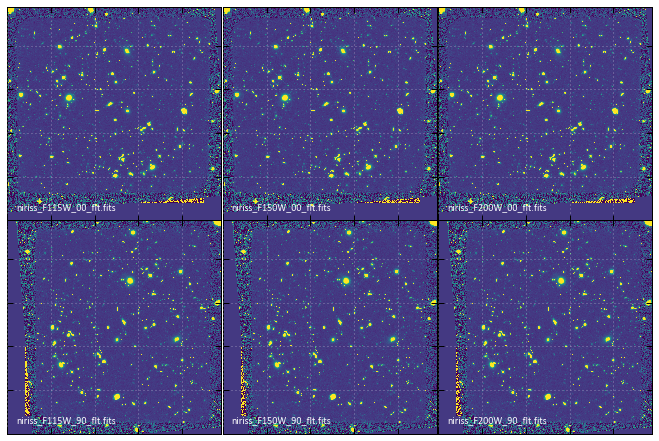

In [135]:
# Blotted reference image 
# "grism" exposures are still empty, just noise
fig = plt.figure(figsize=[9,9*2./3])
for ix, i in enumerate([0,2,4,1,3,5]):
    ax = fig.add_subplot(2,3,ix+1)
    ax.imshow(sim.FLTs[i].direct['REF'], vmin=-0.01, vmax=0.05, cmap='viridis', origin='lower')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.grid(color='w', alpha=0.8)
    ax.text(100,100,sim.FLTs[i].grism_file, color='w', size=10, ha='left', va='bottom')
fig.tight_layout(pad=0.1)

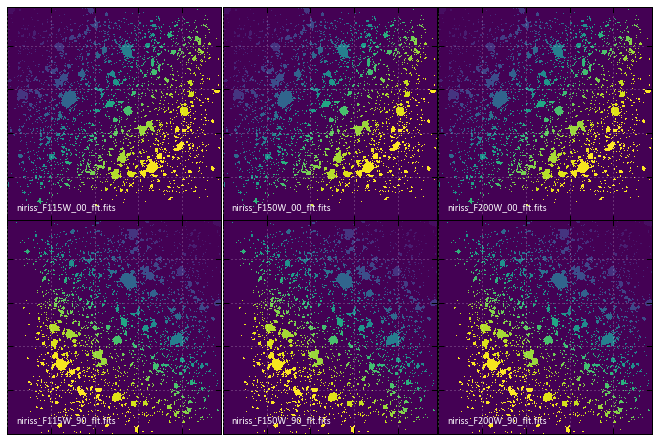

In [134]:
# Blotted segmentation image 
# "grism" exposures are still empty, just noise
fig = plt.figure(figsize=[9,9*2./3])
for ix, i in enumerate([0,2,4,1,3,5]):
    ax = fig.add_subplot(2,3,ix+1)
    ax.imshow(sim.FLTs[i].seg, vmin=-0.01, vmax=3000, cmap='viridis', origin='lower')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.grid(color='w', alpha=0.8)
    ax.text(100,100,sim.FLTs[i].grism_file, color='w', size=10, ha='left', va='bottom')
fig.tight_layout(pad=0.1)

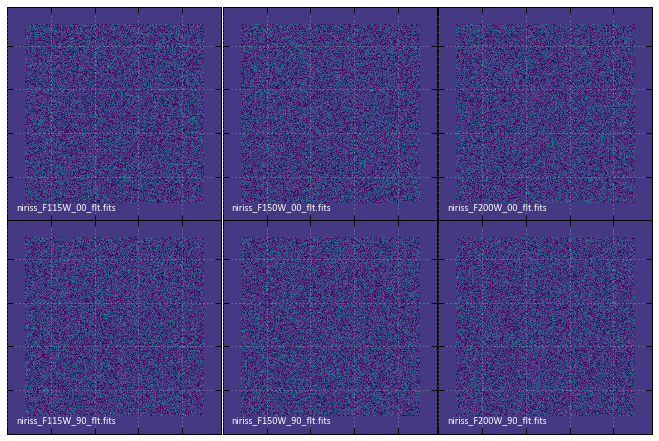

In [133]:
# "grism" exposures are still empty, just noise
fig = plt.figure(figsize=[9,9*2./3])
for ix, i in enumerate([0,2,4,1,3,5]):
    ax = fig.add_subplot(2,3,ix+1)
    ax.imshow(sim.FLTs[i].grism['SCI'], vmin=-0.01, vmax=0.05, cmap='viridis', origin='lower')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.grid(color='w', alpha=0.8)
    ax.text(100,100,sim.FLTs[i].grism_file, color='w', size=10, ha='left', va='bottom')
fig.tight_layout(pad=0.1)

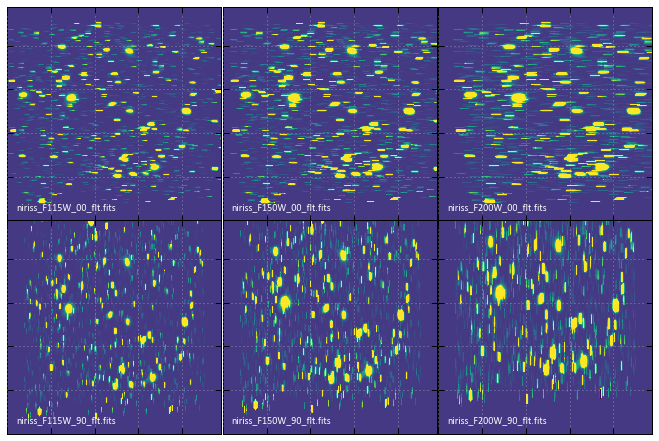

In [132]:
# Model stored in `FLTs[i].model` attribute
fig = plt.figure(figsize=[9,9*2./3])
for ix, i in enumerate([0,2,4,1,3,5]):
    ax = fig.add_subplot(2,3,ix+1)
    
    # show as if it were the rotated grism
    if (i % 2) > 0:
        ax.imshow(np.rot90(sim.FLTs[i].model,-1), vmin=-0.01, vmax=0.05, cmap='viridis', origin='lower')
    else:
        ax.imshow(sim.FLTs[i].model, vmin=-0.01, vmax=0.05, cmap='viridis', origin='lower')

    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.grid(color='w', alpha=0.8)
    ax.text(100,100,sim.FLTs[i].grism_file, color='w', size=10, ha='left', va='bottom')
fig.tight_layout(pad=0.1)

In [12]:
# Update SCI extension of the fake FLT images with the models just computed
for flt in sim.FLTs:
    print('Update', flt.grism_file)
    orig_flt = fits.open(flt.grism_file, mode='update')
    orig_flt['SCI'].data += flt.model[flt.pad:-flt.pad, flt.pad:-flt.pad]
    orig_flt.flush()

Update niriss_F115W_00_flt.fits
Update niriss_F115W_90_flt.fits
Update niriss_F150W_00_flt.fits
Update niriss_F150W_90_flt.fits
Update niriss_F200W_00_flt.fits
Update niriss_F200W_90_flt.fits


### Analyze simulated data
Now use a `grizli.multifit.GroupFLT` object to analyze the data as if they were real observations.

In [13]:
# Now reload for fitting
grp = grizli.multifit.GroupFLT(grism_files=glob.glob('niriss_*flt.fits'), direct_files=[], 
                               ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits',
                               seg_file='udf_f140w_photutils_seg.fits',
                               catalog='udf_f140w_photutils.cat',
                               cpu_count=0, pad=200)

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerletThe following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet






The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          arc

Files loaded - 13.02 sec.


In [15]:
# First pass contamination model, flat continuum
grp.compute_full_model(mag_limit=26)

niriss_F115W_00_flt.fits: _compute_model Done
niriss_F115W_90_flt.fits: _compute_model Done
niriss_F150W_00_flt.fits: _compute_model Done
niriss_F150W_90_flt.fits: _compute_model Done
niriss_F200W_00_flt.fits: _compute_model Done
niriss_F200W_90_flt.fits: _compute_model Done
Models computed - 30.09 sec.


In [16]:
# Refine the (polynomial) continuum model for brighter objects
grp.refine_list(poly_order=2, mag_limits=[16, 24], verbose=False)

#### Fit redshifts and emission lines of a single object

In [17]:
## Fit parameters
pzfit, pspec2, pline = grizli.multifit.get_redshift_fit_defaults()

# Redshift fit
pzfit ['zr'] = [0.5, 2.4]
pzfit['dz'] = [0.005, 0.0005]

# Drizzled line maps
pline = {'kernel': 'square', 'pixfrac': 0.8, 'pixscale': 0.06, 'size': 10}

# Full rectified 2D spectrum
pspec2 = {'NY': 20, 'dlam': 50, 'spatial_scale': 1}

First iteration: z_best=2.3383

 Zoom iteration: z_best=2.3417

Drizzle line -> Ha   (0.87 0.05)
Drizzle line -> OIII (0.47 0.12)
Drizzle line -> Hb   (0.20 0.05)


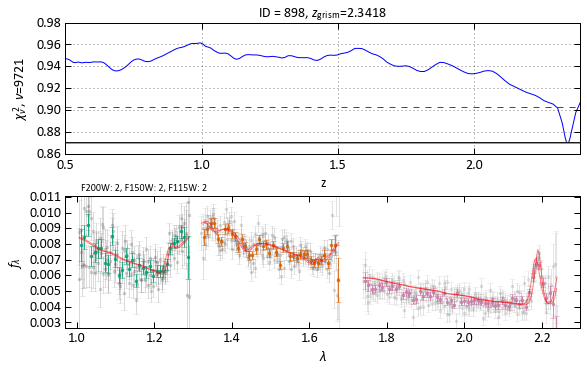

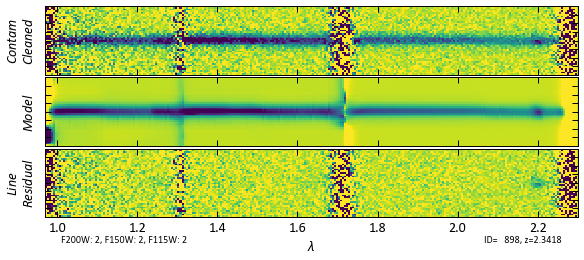

In [33]:
from importlib import reload
reload(grizli.multifit)

## emission line object
id = 898 # ID in the detection catalog / segm image

# Extract spectrum cutouts from individual FLTs
beams = grp.get_beams(id, size=40)

# Put them in a `MultiBeam` object
mb = grizli.multifit.MultiBeam(beams, fcontam=1, group_name='niriss-udf')

# Run the redshift fit and generate the emission line map
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)

fit, fig, fig2, hdu2, hdu_line = out

### A look at individual spectra (filters & orients) in more detail

In [124]:
cmap = 'viridis_r'

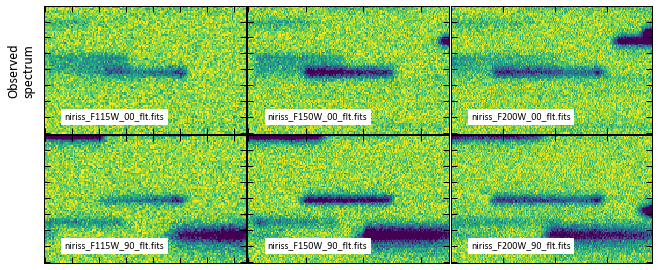

In [90]:
# "Beams" are extracted spectra of a given order.  Have attributes for contam, model etc.
fig = plt.figure(figsize=[9,9*1.2/3])
for ix, i in enumerate([0,2,4,1,3,5]):
    ax = fig.add_subplot(2,3,ix+1)
    beam = mb.beams[i]
    ax.imshow(beam.grism['SCI'], vmin=-0.01, vmax=0.05, cmap=cmap, origin='lower', aspect='auto')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.text(0.1,0.1,beam.grism.parent_file, color='k', backgroundcolor='w', transform=ax.transAxes,
            size=10, ha='left', va='bottom')

fig.axes[0].set_ylabel('Observed\nspectrum')
fig.tight_layout(pad=0.1)

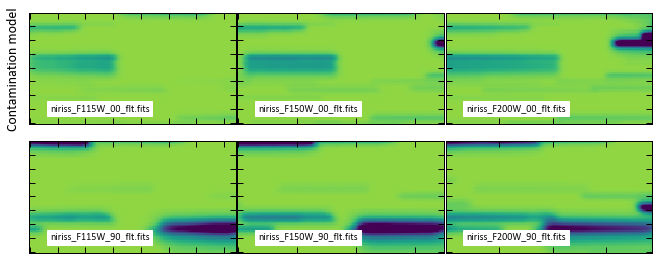

In [91]:
# Each beam carries with it a static contamination model extracted from the full field
fig = plt.figure(figsize=[9,9*1.2/3])
for ix, i in enumerate([0,2,4,1,3,5]):
    ax = fig.add_subplot(2,3,ix+1)
    beam = mb.beams[i]
    ax.imshow(beam.contam, vmin=-0.01, vmax=0.05, cmap=cmap, origin='lower', aspect='auto')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.text(0.1,0.1,beam.grism.parent_file, color='k', backgroundcolor='w', transform=ax.transAxes,
            size=10, ha='left', va='bottom')

fig.axes[0].set_ylabel('Contamination model')
fig.tight_layout(pad=0.1)

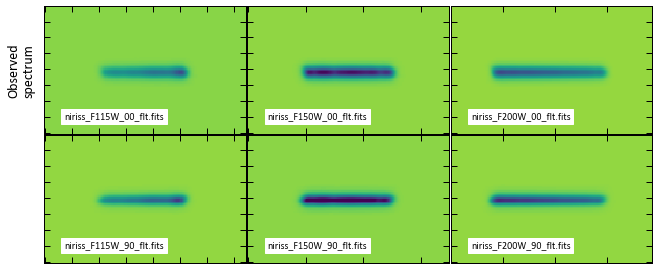

In [92]:
# Under the hood, the fitting is done by specifying a single 1D template, which 
# is used to generate model 2D spectra for each beam
fig = plt.figure(figsize=[9,9*1.2/3])
for ix, i in enumerate([0,2,4,1,3,5]):
    ax = fig.add_subplot(2,3,ix+1)
    beam = mb.beams[i]
    ax.imshow(beam.model, vmin=-0.01, vmax=0.05, cmap=cmap, origin='lower', aspect='auto')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.text(0.1,0.1,beam.grism.parent_file, color='k', backgroundcolor='w', transform=ax.transAxes,
            size=10, ha='left', va='bottom')

fig.axes[0].set_ylabel('Observed\nspectrum')
fig.tight_layout(pad=0.1)

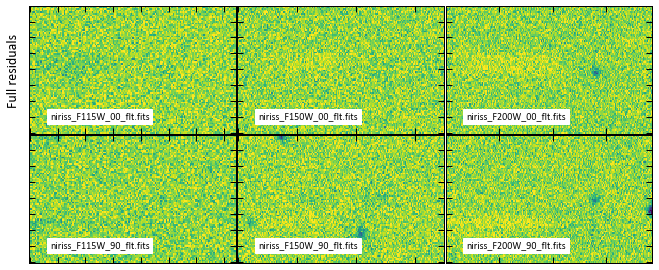

In [93]:
# Goodness of fit is computed by comparing the models in the full 2D pixel space
fig = plt.figure(figsize=[9,9*1.2/3])
for ix, i in enumerate([0,2,4,1,3,5]):
    ax = fig.add_subplot(2,3,ix+1)
    beam = mb.beams[i]
    ax.imshow(beam.grism['SCI'] - beam.contam - beam.model, vmin=-0.01, vmax=0.05, cmap=cmap, 
              origin='lower', aspect='auto')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.text(0.1,0.1,beam.grism.parent_file, color='k', backgroundcolor='w', transform=ax.transAxes,
            size=10, ha='left', va='bottom')

fig.axes[0].set_ylabel('Full residuals')
fig.tight_layout(pad=0.1)

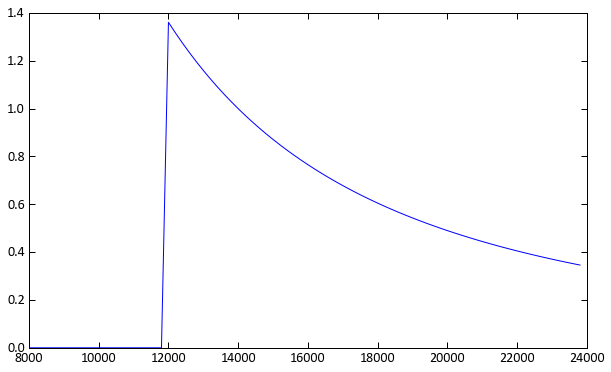

In [97]:
# Trivial demo model, dropout in the middle of the F115W filter
xspec = np.arange(0.8,2.4,0.02)*1.e4
yspec = (xspec/1.4e4)**(-2) # Beta=-2
yspec[xspec < 1.2e4] = 0.
plt.plot(xspec, yspec)
mb.compute_model(spectrum_1d=[xspec, yspec])

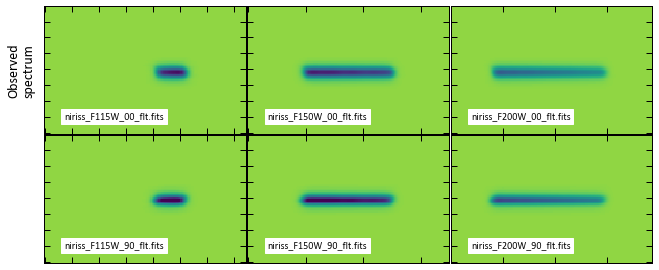

In [99]:
fig = plt.figure(figsize=[9,9*1.2/3])
for ix, i in enumerate([0,2,4,1,3,5]):
    ax = fig.add_subplot(2,3,ix+1)
    beam = mb.beams[i]
    ax.imshow(beam.beam.model, vmin=-0.01, vmax=0.05, cmap=cmap, origin='lower', aspect='auto')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.text(0.1,0.1,beam.grism.parent_file, color='k', backgroundcolor='w', transform=ax.transAxes,
            size=10, ha='left', va='bottom')

fig.axes[0].set_ylabel('Observed\nspectrum')
fig.tight_layout(pad=0.1)

### Drizzled emission line map

In [125]:
# Emission line map
line = fits.open('niriss-udf_zfit_00898.line.fits')
print(line[0].header['HASLINES'])
line.info()

Ha OIII Hb
Filename: niriss-udf_zfit_00898.line.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      34   ()              
1    DSCI        ImageHDU        20   (166, 166)   float32   
2    DWHT        ImageHDU        20   (166, 166)   float32   
3    LINE        ImageHDU        24   (166, 166)   float32   
4    CONTINUUM   ImageHDU        24   (166, 166)   float32   
5    CONTAM      ImageHDU        24   (166, 166)   float32   
6    LINEWHT     ImageHDU        24   (166, 166)   float32   
7    LINE        ImageHDU        24   (166, 166)   float32   
8    CONTINUUM   ImageHDU        24   (166, 166)   float32   
9    CONTAM      ImageHDU        24   (166, 166)   float32   
10   LINEWHT     ImageHDU        24   (166, 166)   float32   
11   LINE        ImageHDU        24   (166, 166)   float32   
12   CONTINUUM   ImageHDU        24   (166, 166)   float32   
13   CONTAM      ImageHDU        24   (166, 166)   float32   
14   LINEWHT     ImageHDU   

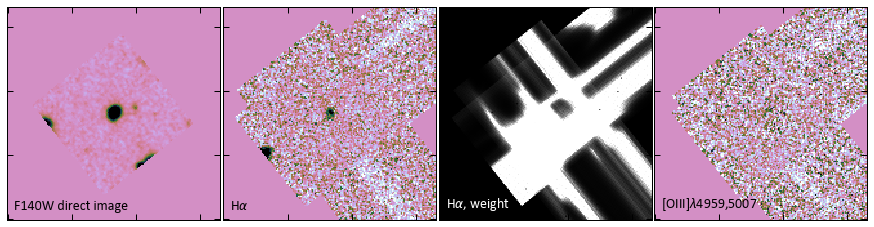

In [126]:
cmap = 'cubehelix_r'
fig = plt.figure(figsize=[12,3])

ax = fig.add_subplot(141)
ax.imshow(line['DSCI'].data, vmin=-0.01, vmax=0.02, cmap=cmap, origin='lower')
ax.text(5,5,'F140W direct image', ha='left', va='bottom')

ax = fig.add_subplot(142)
ax.imshow(line['LINE', 'Ha'].data, vmin=-0.01, vmax=0.02, cmap=cmap, origin='lower')
ax.text(5,5,r'H$\alpha$', ha='left', va='bottom')

ax = fig.add_subplot(143)
ax.imshow(line['LINEWHT', 'Ha'].data, vmin=-0.01, vmax=20000, cmap='gray', origin='lower')
ax.text(5,5,r'H$\alpha$, weight', ha='left', va='bottom', color='w')

ax = fig.add_subplot(144)
ax.imshow(line['LINE', 'OIII'].data, vmin=-0.03, vmax=0.06, cmap=cmap, origin='lower')
ax.text(5,5,r'[OIII]$\lambda$4959,5007', ha='left', va='bottom')

for ax in fig.axes:
    ax.set_xticklabels([]); ax.set_yticklabels([])

fig.tight_layout(pad=0.1)